In [299]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [300]:
# Đường dẫn đến các tập dữ liệu
usd_data_path = '/content/drive/MyDrive/dataset/US Dollar Index Futures Historical Data.csv'
bitcoin_data_path = '/content/drive/MyDrive/dataset/Bitcoin Historical Data.csv'
nasdaq_data_path = '/content/drive/MyDrive/dataset/NASDAQ Composite Historical Data.csv'

In [301]:
# Load and process datasets
def load_and_process_data(data_path):
    df = pd.read_csv(data_path)
    if 'Price' in df.columns:
        if df['Price'].dtype == 'object':
            df['Price'] = df['Price'].str.replace(',', '').astype(float)
        return df['Price'].values.reshape(-1, 1)
    else:
        raise ValueError("Column 'Price' not found in the dataset.")

In [302]:
# Định nghĩa hàm đánh giá mô hình
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, mape, rmse

In [303]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [304]:
def reverse_dataset(dataset):
    return dataset[::-1]  # Reverse the dataset

In [305]:
def process_and_plot(data_path, title):
    df = pd.read_csv(data_path)
    df = reverse_dataset(df)
    df['Price'] = df['Price'].str.replace(',', '').astype(float)
    df1 = df['Price'].values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    df1 = scaler.fit_transform(df1)

    train_size = int(0.8 * len(df1))
    test_size = len(df1) - train_size
    train_data = df1[:train_size]
    test_data = df1[train_size:]

    time_step = 100
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, batch_size=64, verbose=1)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    y_pred_train = scaler.inverse_transform(y_pred_train)
    y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_pred_test = scaler.inverse_transform(y_pred_test)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    print(f'{title} Training RMSE:', train_rmse)
    print(f'{title} Testing RMSE:', test_rmse)

    mae, mape, rmse = evaluate_model(y_test, y_pred_test)
    print(f'{title} Evaluation:')
    print(f'MAE: {mae}, MAPE: {mape}, RMSE: {rmse}')

    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(train_data)), scaler.inverse_transform(train_data), label='Training Data')
    plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Testing Data')
    plt.plot(np.arange(len(train_data), len(train_data) + len(y_pred_test)), y_pred_test, label='Testing Predictions')

    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(f'LSTM with {title} Stock Time Series Forecast (ratio 8:2)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [306]:
def process_and_plot_us(data_path, title):
    df = pd.read_csv(data_path)
    df = reverse_dataset(df)
    df1 = df['Price'].values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    df1 = scaler.fit_transform(df1)

    train_size = int(0.8 * len(df1))
    test_size = len(df1) - train_size
    train_data = df1[:train_size]
    test_data = df1[train_size:]

    time_step = 100
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, batch_size=64, verbose=1)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    y_pred_train = scaler.inverse_transform(y_pred_train)
    y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_pred_test = scaler.inverse_transform(y_pred_test)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    print(f'{title} Training RMSE:', train_rmse)
    print(f'{title} Testing RMSE:', test_rmse)

    mae, mape, rmse = evaluate_model(y_test, y_pred_test)
    print(f'{title} Evaluation:')
    print(f'MAE: {mae}, MAPE: {mape}, RMSE: {rmse}')

    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(train_data)), scaler.inverse_transform(train_data), label='Training Data')
    plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Testing Data')
    plt.plot(np.arange(len(train_data), len(train_data) + len(y_pred_test)), y_pred_test, label='Testing Predictions')

    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(f'LSTM with {title} Stock Time Series Forecast (ratio 8:2)')
    plt.legend()
    plt.grid(True)
    plt.show()

Bitcoin data shape: (4111, 1)
NASDAQ data shape: (2833, 1)
USD data shape: (2907, 1)
23/23 [==============================] - 1s 40ms/step
Bitcoin Training RMSE: 2159.7380889369656
Bitcoin Testing RMSE: 3121.850366783234
Bitcoin Evaluation:
MAE: 2085.348505575726, MAPE: 6.410180140605452, RMSE: 3121.850366783234


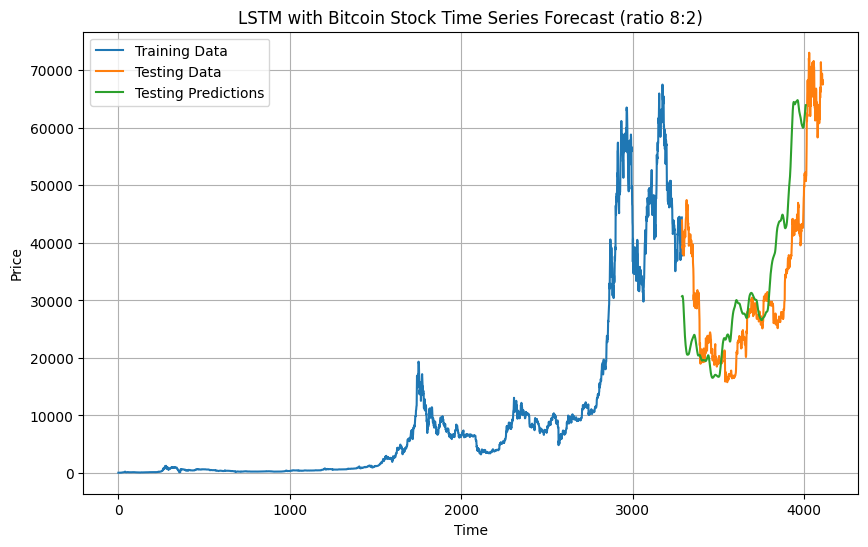

15/15 [==============================] - 1s 37ms/step
NASDAQ Training RMSE: 650.1294530039231
NASDAQ Testing RMSE: 1044.954083236659
NASDAQ Evaluation:
MAE: 933.7099666254015, MAPE: 6.886994499960044, RMSE: 1044.954083236659


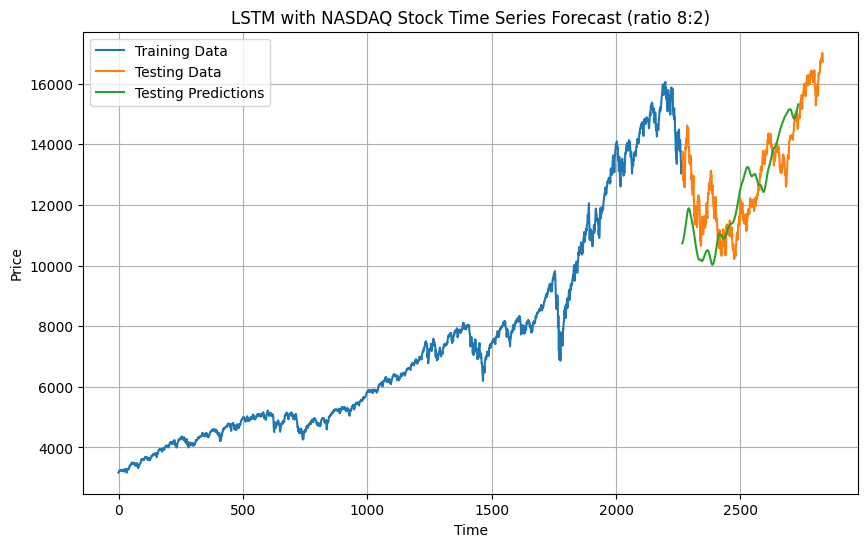

16/16 [==============================] - 1s 37ms/step
USD Training RMSE: 2.078438178915611
USD Testing RMSE: 5.240843601367516
USD Evaluation:
MAE: 4.931428925067062, MAPE: 4.677387372663501, RMSE: 5.240843601367516


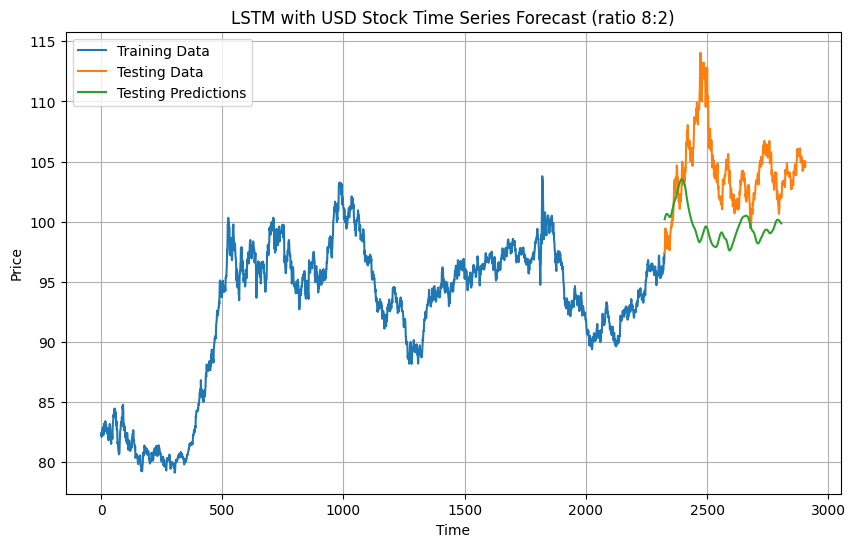

In [307]:
# Load datasets
bitcoin_data = load_and_process_data(bitcoin_data_path)
nasdaq_data = load_and_process_data(nasdaq_data_path)
usd_data = load_and_process_data(usd_data_path)

print("Bitcoin data shape:", bitcoin_data.shape)
print("NASDAQ data shape:", nasdaq_data.shape)
print("USD data shape:", usd_data.shape)

process_and_plot(bitcoin_data_path, 'Bitcoin')
process_and_plot(nasdaq_data_path, 'NASDAQ')
process_and_plot_us(usd_data_path, 'USD')